# Assemble a test set
We want the most stable clusters for each size and, where possible, additional graphs selected randomly from the remaining.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
from queue import PriorityQueue, Empty
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import random
import gzip
import json

Configuration

In [2]:
random.seed(123)
n_best = 50
n_random = 50

## Get the best clusters and count the total number
For each size, we want the best clusters and need to know how many exist for the size in order to pick randomly.

We use an out-of-core strategy because the datasets are too big to fit in memory

In [3]:
file = Path('../data/output/geom_test.json.gz')

Initialize the counters and storage for best clusters.

In [4]:
counter = defaultdict(int)  # So that we can pick from the list randomly later
best_clusters_queue = defaultdict(PriorityQueue)  # To store the best clusters

In [5]:
# Loop over each line of each file
with gzip.open(file, 'rt') as fp:
    for line in tqdm(fp, desc=str(file)):
        # Read the record and update the count
        record = json.loads(line)

        # Get the cluster count and energy
        n_waters = record['n_water']
        energy = record['energy']

        # Add it to the "best queue"
        #  We use the negative energy to sort so that the least stable is at front
        #  We also store the index of this cluster within the those of this size,
        #   which will allow us to exclude the cluster from random selection later
        best_clusters_queue[n_waters].put((-energy, counter[n_waters], line))
        if counter[n_waters] >= n_best:
            # Remove the worst cluster if we have read more than num_best
            best_clusters_queue[n_waters].get()

        # Update the cluster count
        counter[n_waters] += 1

../data/output/geom_test.json.gz: 223448it [00:09, 23171.81it/s]


Store the best clusters in a single list, store their positions within the lists

In [6]:
output_clusters = []
best_pos = defaultdict(list)
for n_waters, queue in best_clusters_queue.items():
    while True:
        try:
            _, pos, line = queue.get_nowait()
        except Empty:
            break
            
        # Unparse the record
        record = json.loads(line)
        
        # Store the source of the record
        record['source'] = 'best'
        
        # Append to the total list
        output_clusters.append(record)
        
        # Store the position
        best_pos[n_waters].append(pos)

## Get clusters randomly
We can now pick clusters randomly now that we know how many clusters exist for each size and which ones are the 'best.'

First step is to pick the random positions by sampling from all clusters of each size except those that are best

In [7]:
random_positions = {}
for size, to_exclude in sorted(best_pos.items()):  # Iterate in size order for repeatability
    # Make a set that represents all clusters of a certain size
    total_count = counter[size]
    options = set(range(total_count))
    
    # Remove the best ones
    options.difference_update(to_exclude)
    
    # Pick randomly from what remains, if we have enough
    if len(options) <= n_best:
        choices = options
    else:
        choices = random.sample(options, k=n_best)
        
    # Store the sorted choices, for convenience lookup later
    random_positions[size] = sorted(choices)

Retrieve the random positions from the data

In [8]:
position = defaultdict(int)

In [9]:
# Loop over each line of each file
with gzip.open(file, 'rt') as fp:
    for line in tqdm(fp, desc=str(file)):
        # Read the record and update the count
        record = json.loads(line)

        # Get the cluster count and energy
        n_waters = record['n_water']

        # If the index of this cluster is one of our random ones, store it
        my_checklist = random_positions[n_waters]
        if len(my_checklist) > 0 and position[n_waters] == my_checklist[0]:  # random_positions is sorted, so we know [0] is the next cluster
            # We've found this choice, so remove it from list
            my_checklist.pop(0)

            # Store the record in the selections
            record['source'] = 'random'
            output_clusters.append(record)

        # Update position
        position[n_waters] += 1

../data/output/geom_test.json.gz: 223448it [00:09, 24568.23it/s]


## Display the results before saving
Check how many we picked per cluster size and the energy distributions

In [10]:
output_clusters = pd.DataFrame(output_clusters)

In [11]:
count_summary = output_clusters.groupby(['n_water', 'source'])['z'].count()

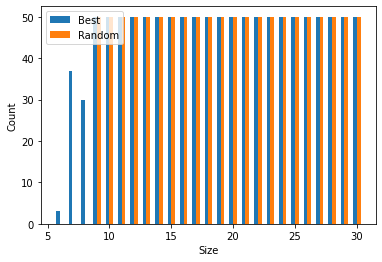

In [12]:
fig, ax = plt.subplots()

width = 0.3
for (source, counts), offset in zip(count_summary.groupby('source'), [-width/2, width/2]):
    ax.bar(counts.index.get_level_values('n_water') + offset, counts, label=source.capitalize(), width=width, align='center')
    
ax.set_xlabel('Size')
ax.set_ylabel('Count')
ax.legend()

We have fifty per cluster size, as desired

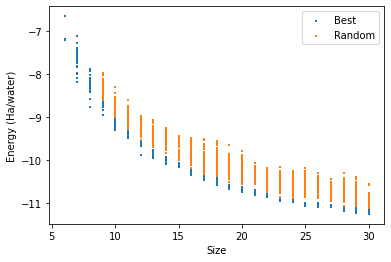

In [13]:
fig, ax = plt.subplots()

for source, group in output_clusters.groupby('source'):
    ax.scatter(group['n_water'], group['energy'] / group['n_water'], marker='+', s=3, label=source.capitalize())
    
ax.set_xlabel('Size')
ax.set_ylabel('Energy (Ha/water)')

ax.legend()

As expected, randomly-selected clusters have a higher energy than the "best"

## Save to Disk
In a JSON format so it is easy to get later

In [14]:
with open('benchmark_clusters.json', 'w') as fp:
    for record in output_clusters.to_dict('records'):
        print(json.dumps(record), file=fp)